# Chapter 3 - Classification

**NOTES**

- **Accuracy** is not always a good metric for performance, specially if you have a ds with many negative values. For example, if you're detecting cancer, but you only have 5% of cancer values in your DS, if you randomly say a value if not cancer you will still  be right in 95% of the times.

-  Make sure you suffle the data and use stratified CV to have a good represenation in your train and test sets.

- **Performance metrics:** Precision, Recall, F-score. Check Confusion Matrix. 

- If needed, manipulate decision threshold. 

In [25]:
# loads common libraries
import sklearn
import numpy as np

# to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib as mpl
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
mpl.rc("font", family="Azeret Mono", weight="bold")

In [26]:
# loads the famouse ds with handwritten numbers

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [21]:
X, y = mnist["data"], mnist["target"]

print(f"X shape: {X.shape} \ny shape: {y.shape}")

X shape: (70000, 784) 
y shape: (70000,)


In [45]:
# split data into train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 1.0 Training a binary classifier

We will start by training a simple binary classifier. The goal here is to check if a digit is "5" or not.

In [49]:
# check what y returns, the labels
y_train[:10]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

In [50]:
# we will create a binary target, if it's 5 or not
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

In [51]:
y_train_5[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [54]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

y_pred = sgd_classifier.predict(X_test)

# First 10 predicitons on y_test
print("First 10 predictions on X_test")
print(y_pred[:10])

# First 10 values y_test
print("First 10 y_test_5 values")
print(y_test_5[:10])


First 10 predictions on X_test
[False False False False False False False False False False]
First 10 y_test_5 values
[False False False False False False False False  True False]


## 1.1 Performance measures

### 1.1.1 Accuracy

In [55]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### 1.1.2 Confusion Matrix

A confusion matrix always goes:

- First row: negative values (the first column is the real negative values, the second column is the negative values classified wrong (false positive))
- Second row: positive values (the first column is the real positive values, the second column is the positive values classified wrong (false positive))

The left diagonal represents the "true values". So a perfect confusion matrix would be something like:

[ [number 0]]

[[0 number]]

In [57]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# here we will make predictions on the train set, to avoid touching the test set for now
y_train_predic = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=5)

conf_matrix = confusion_matrix(y_train_5, y_train_predic)

print(conf_matrix)

[[53115  1464]
 [  916  4505]]


**PRECISION**: Accuracy of the positive predictions

precision = TP / (TP+FP)

**RECALL** The ratio of positive precitions that was correctly dected

recall = TP / (TP + FN)

In [60]:
from sklearn.metrics import precision_score, recall_score

print("Precision Score:")
print(precision_score(y_train_5, y_train_predic))

print("Recall score:")
print(recall_score(y_train_5, y_train_predic))

Precision Score:
0.7547327860613168
Recall score:
0.8310274857037447


This means the classifier only gets 83% of the true 5 values (recall) and that he's only right in 75% of tje cases (precision).

**The F1-SCORE** is the harmonic mean between precision and recall, and it can be used a trade-off between both metrics.

f1 = TP / ((TP + ((FN + FP)/2)))

In [61]:
from sklearn.metrics import f1_score

print("F1 Score")
print(f1_score(y_train_5, y_train_predic))

F1 Score
0.7910447761194029


### 1.1.3 Decision function threshold

The classification/prediction happens based on a threshold. If the number is higher than that threshold than it's classified as positive and as negative otherwise. You can't manually set the threshold, you can check them and so generate new predictions based on the values you want.

In [69]:
y_scores = sgd_classifier.decision_function([X_train[0]])

print(y_scores)

[2164.22030239]


In [70]:
threshold = 0

y_decision_manual_pred = (y_scores > threshold)

y_decision_manual_pred

array([ True])

In [71]:
# but if when change the value of the threshold, the prediction changes
threshold = 3000

y_decision_manual_pred = (y_scores > threshold)

y_decision_manual_pred

array([False])

In [72]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=5, method="decision_function")

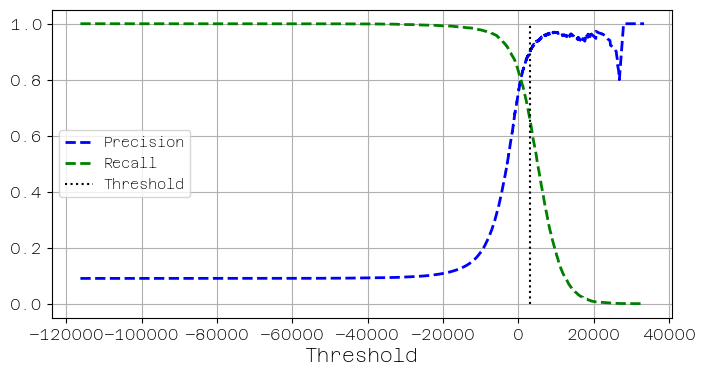

In [76]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label= "Threshold")

plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center left")


plt.show()

Precision/Recall have a trade-off. A good threshold is when the precision goes up but before recall goes down.
Another way to select a good precision/recall tradeoff is to plot these metrics against each other.
Then you look where precision starts to fall sharply (in the graph below it's around 0.8 recall)

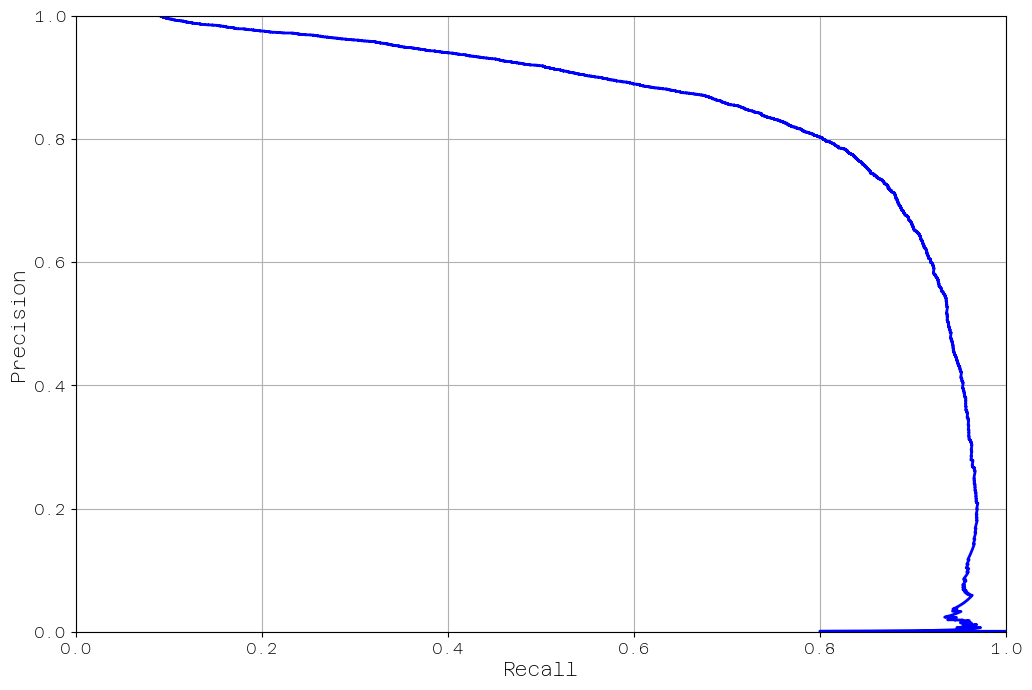

In [80]:
plt.figure(figsize=(12, 8))
plt.plot(precisions, recalls, "b-", linewidth=2)
plt.axis([0, 1, 0, 1])

plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.show()

### 1.1.4 ROC Curve

The ROC curve plots recall versus (1-true negative rate). 
**A good way to compare classifiers is to get the score of the area under the curve AUC. A perfect classifier has a ROC AUC of 1**.

In [81]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9648211175804801)

## 1.2 Multiclass classifiers